# Explore a synthetic dataset without dependencies

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from empirical_copula import (
    empirical_joint_pmf_details,
    empirical_marginal_pmf,
    independent_pmf,
    joint_counts,
    order_pmf,
)
from empirical_copula.plot import (
    copula_pcolormesh,
    significance_copula_pcolormesh,
)
from empirical_copula.significance import significance_from_bootstrap

# Create the dataset

We create two discrete random variables `v1` and `v2`, and assign a probability for observing each pair of values.

The probabilities are defined such that the marginal distribution of the variables is not uniform, but the veriables are independent.

In [2]:
random_state = np.random.RandomState(4871)

# generate two correlated time series
values1 = list('ABCDEF')  # Categorical
values2 = [1, 2, 3, 4]  # Ordinal

p1 = random_state.uniform(size=len(values1))
p1 /= p1.sum()

p2 = random_state.uniform(size=len(values2))
p2 /= p2.sum()

Observe samples from this distribution

In [19]:
# Create random series
n = 1000
samples = pd.DataFrame(
    {
        'v1': random_state.choice(np.array(values1), p=p1, size=(n,)), 
        'v2': random_state.choice(np.array(values2), p=p2, size=(n,))
    }
)
samples.head()

,v1,v2
0,A,1
1,D,2
2,A,2
3,E,4
4,C,2


# Compute the marginal and joint distribution

In [20]:
pmf1, pmf2, empirical_pmf, others = empirical_joint_pmf_details(samples)
pmf1 = order_pmf(pmf1, is_ordinal=False)
pmf2 = order_pmf(pmf2, is_ordinal=True)

Plotting the empirical joint distribution as a heatmap, it's unclear whether there is a dependency or none.

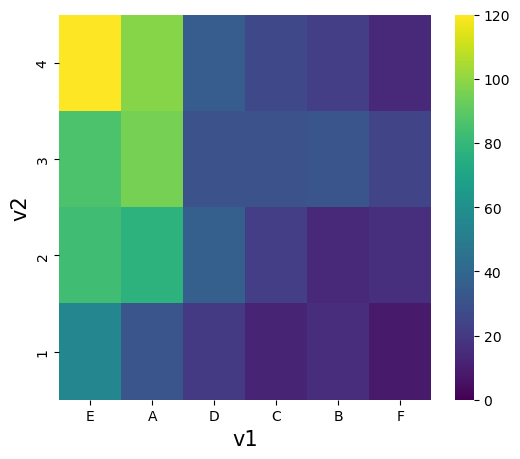

In [21]:
with plt.rc_context({'figure.figsize': (6, 5)}):
    ax = sns.heatmap(others['counts'].loc[pmf1.index, pmf2.index].T, cmap='viridis', vmin=0)
    ax.invert_yaxis()
    plt.xlabel('v1', fontsize=15)
    plt.ylabel('v2', fontsize=15)

Comparing with the joint distribution expected if the two variables were independent, we see that any dependency would be weak.

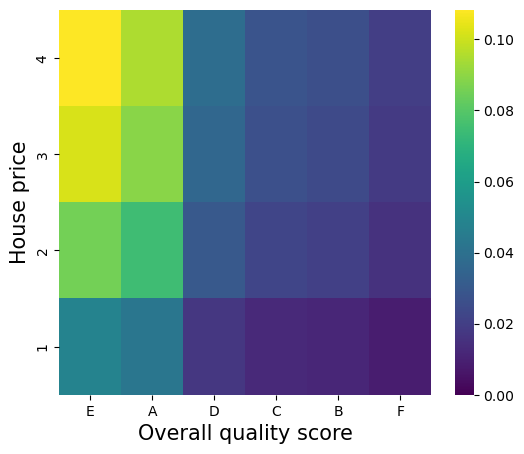

In [22]:
# Expected joint pmf if the two variables were independent
with plt.rc_context({'figure.figsize': (6, 5)}):
    ax = sns.heatmap(others['ind_pmf'].loc[pmf1.index, pmf2.index].T, cmap='viridis', vmin=0)
    ax.invert_yaxis()
    plt.xlabel('Overall quality score', fontsize=15)
    plt.ylabel('House price', fontsize=15)


# Visualize the empirical copula

Independent variables would have an empirical copula with a uniform value of 1.0 . 

We visualize the log10 of the observed copula values. The interpretation of this number is the log of the factor with which a given combination of values is observed compared to the expectation under the hypothesis of independence. For instance, a value of 0.5 in the plot below means that that combination of values appears 10^0.5 = 3.2 times more often than expected if the variables were independent.

In [23]:
diff_from_uniform = np.log10(empirical_pmf.replace(0, 1))

By construction, the variables are independent and so we expect to observe a uniform empirical copula. Any deviation would be noise due to small sample size.

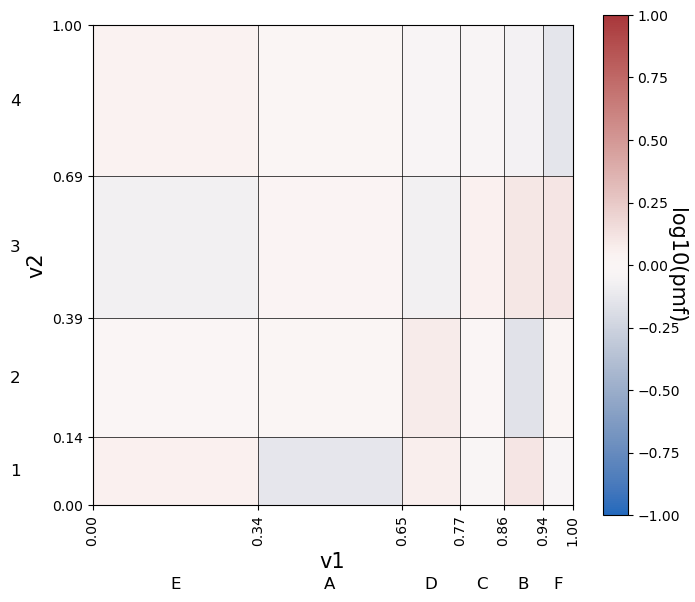

In [24]:
grid_lw = 0.5
max_diff_color = 1

with plt.rc_context({'figure.figsize': (6, 5)}):
    fig = plt.gcf()
    ax, pcm = copula_pcolormesh(fig, pmf1, pmf2, diff_from_uniform, grid_lw=grid_lw, 
                                vmin=-max_diff_color, vmax=max_diff_color, cmap='vlag', annotation_fontsize=12)
    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label('log10(pmf)', fontsize=15, rotation=270)
    plt.xlabel('v1', fontsize=15)
    plt.ylabel('v2', fontsize=15)

# Which of the observed deviations from independence are significant?

Are the strong dependencies observed in the tail statistically significant, or are they just noise due to the small sample site for those combination of values?

We can destroy the dependencies between the variables by resampling them replacement independently from each other. Doing this many times gives us an estimate of the distribution of the frequencies we would observe with the same marginal distribution if the variables were independent. We can then look at how extreme what we observe is compared to this 0-hypothesis distribution and derive a significance level.

In [27]:
random_state = np.random.RandomState(1212)
quantile_levels, quantile_levels_labels, significance = significance_from_bootstrap(
    samples, n_bootstraps=5000, p_levels_low=[0.001, 0.01, 0.05, 0.1], random_state=random_state)

The significance plot confirms that the observed dependencies are not significant. Some weak significance is sometimes observed, but multiplt comparisons should be factored in in the interpretation.

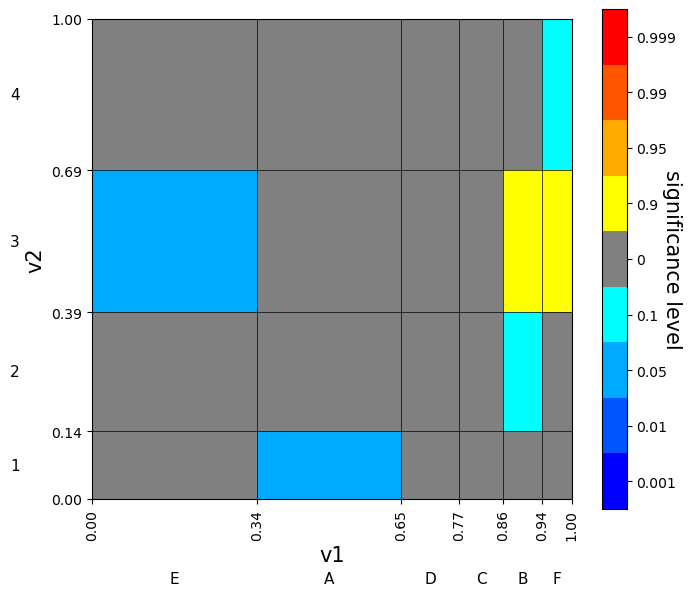

In [28]:
with plt.rc_context({'figure.figsize': (6, 5)}):
    fig = plt.gcf()
    significance_copula_pcolormesh(fig, pmf1, pmf2, significance, quantile_levels, grid_lw=grid_lw, annotation_fontsize=11)
    plt.xlabel('v1', fontsize=15)
    plt.ylabel('v2', fontsize=15)